In [21]:
pip install statsmodels --upgrade

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import statsmodels

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from math import sqrt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf

from pandas import read_csv
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

from google.colab import drive
drive.mount('/content/drive')
images_dir = '/content/drive/MyDrive/CS229_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def ARIMA(prices):
	# split the data
	train_test_split=.8
	train_test_split = round(train_test_split * prices.shape[0])

	#construct train and test sets
	train, test = prices.values[:train_test_split], prices.values[train_test_split:]

	#select optimal number of lags
	num_lags = ar_select_order(prices, maxlag=50)
	sequence_length = len(num_lags.ar_lags)
	model = AutoReg(train, lags=num_lags.ar_lags)
	fit = model.fit()
	prior = list(train[len(train)-sequence_length:])
	predicted = []

	#go through the test set and predict 
	for i in range(len(test)):
		lag_list = list(prior[len(prior)-sequence_length:])
		y_predict = fit.params[0]
		#update y_predict
		for j in range(sequence_length):
			y_predict = y_predict + fit.params[j+1] * lag_list[sequence_length-j-1]
		predicted.append(y_predict)
		prior.append(test[i])
	return test, predicted
 
def rmse(actual, predicted):
	#calculate RMSE
	rmse = sqrt(mean_squared_error(actual, predicted))
	return rmse

def plot_prices(test, predicted, length, days):
	plt.plot(test[:length], label = 'Real Price')
	pred=predicted[:length]
	pyplot.plot(pred, color='red', label = 'Predicted Price')
	plt.xlabel('Time [days]')
	plt.xticks(ticks=np.arange(0, len(pred), 24*days), labels=[days*int(x) for x in np.arange(0, len(pred), 24)/24])
	plt.ylabel('Price [$]')
	plt.legend()
	plt.savefig(f"{images_dir}/ARIMA_LMP_subset.png", dpi=500) 
	plt.show()
 
def plot_lag(prices):
	lag_plot(prices)
	plt.xlabel('Price(t) [$]')
	plt.ylabel('Price(t+1) [$]')
	plt.savefig(f"{images_dir}/ARIMA_lagplot.png", dpi=500)
	plt.show()

def plot_autocorr(prices):
	autocorrelation_plot(prices)
	plt.xlabel('Lags [Hours]')
	plt.savefig(f"{images_dir}/ARIMA_autocorrelation.png", dpi=500)
	plt.show()
 
def plot_autocorr_subset(prices, length):
	plot_acf(prices, lags=length)
	plt.xlabel('Lags [hours]')
	plt.ylabel('Autocorrelation')
	plt.title('')
	plt.savefig(f"{images_dir}/ARIMA_autocorr_lags31.png", dpi=500)
	pyplot.show()
 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


Test RMSE: 6.035


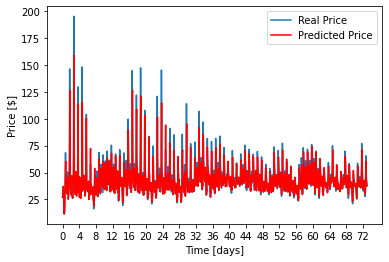

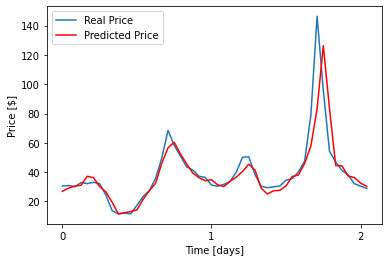

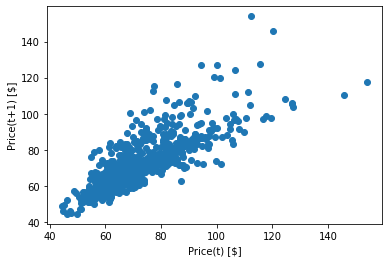

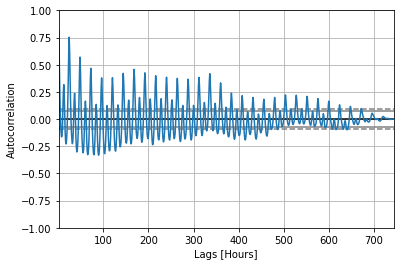

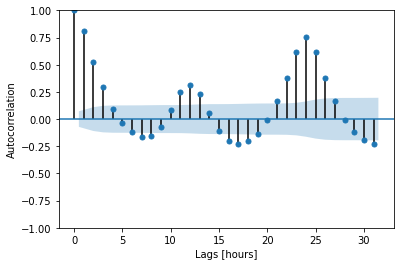

In [28]:
# load the dataset
lmps_pacifica = read_csv('/content/drive/MyDrive/CS229_Project/pacifica_oct_lmp.csv', header=0, index_col=0)
lmps_bellhaven = read_csv('/content/drive/MyDrive/CS229_Project/bellehaven_2019.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

#run ARIMA and print RMSE
test, predicted=ARIMA(lmps_bellhaven)
RMSE = rmse(test, predicted)
print('Test RMSE: %.3f' % RMSE)

#plot predictions
plot_prices(test, predicted, len(test), 4)
plot_prices(test, predicted, 50, 1)

#plot lag plot
plot_lag(lmps_pacifica)

#plot autocorrelation
plot_autocorr(lmps_pacifica)

#plot autocorrelation for first 31 lags 
plot_autocorr_subset(lmps_pacifica, 31)
